In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing the neccassary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm


import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [13]:
train = get_training_data('/content/drive/MyDrive/Colab Notebooks/dataset/train')
test = get_training_data('/content/drive/MyDrive/Colab Notebooks/dataset/test')
val = get_training_data('/content/drive/MyDrive/Colab Notebooks/dataset/val')


<ipython-input-4-b2613b36a4a4>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [14]:
train.shape

(70, 2)

In [15]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("PNEUMONIA")
    else:
        l.append("NORMAL")
sns.set_style('darkgrid')
sns.countplot(l) 

ValueError: ignored

Text(0.5, 1.0, 'NORMAL')

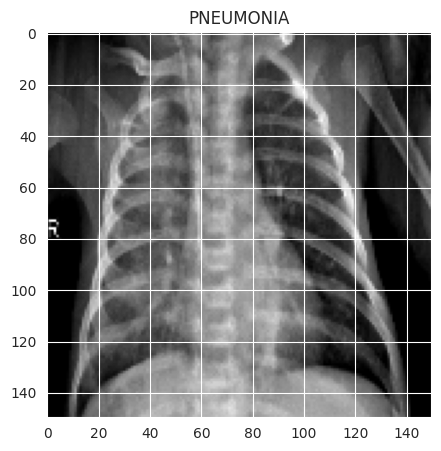

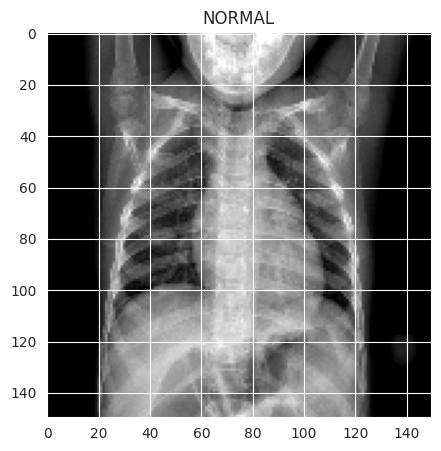

In [16]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

Next, we perform some Data Preprocessing and Data Augmentation before we can proceed with building the model.

In [17]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

Normalizing the data

In [18]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [19]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

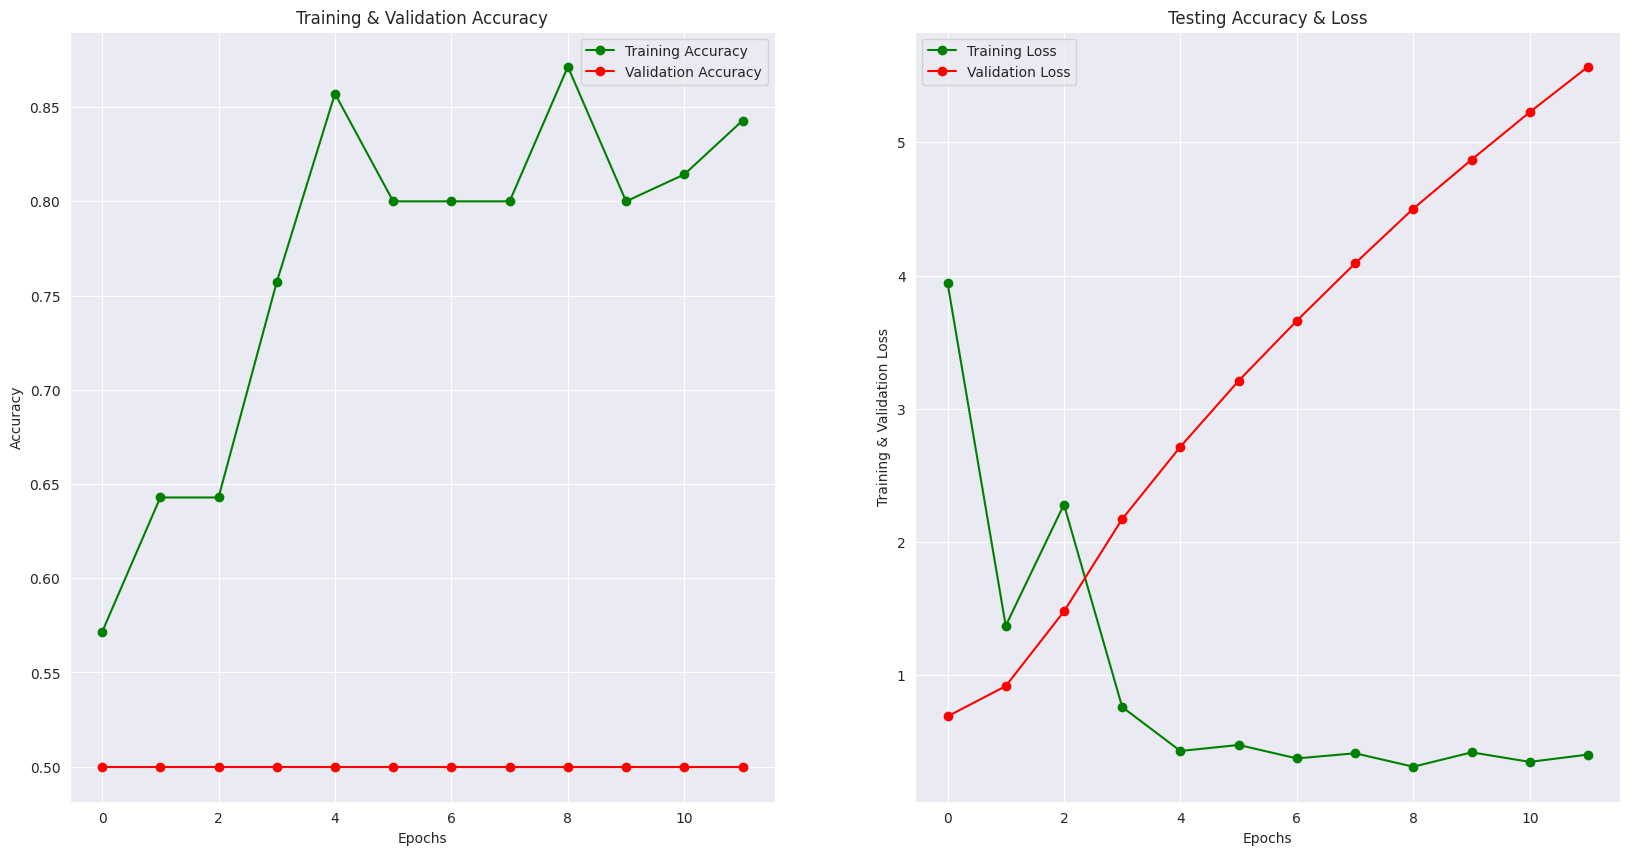

In [23]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [31]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

AttributeError: ignored

In [32]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes[:15])

1/1 [==============================] - 1s 673ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [33]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

ValueError: ignored

In [34]:
from sklearn.metrics import classification_report

# assuming you have a binary classification task, and 'model' is a trained Keras model
predictions = model.predict(x_test)
predicted_classes = (predictions > 0.5).astype(int) # convert probabilities to binary values
target_names = ['Pneumonia (Class 0)','Normal (Class 1)']
print(classification_report(y_test, predicted_classes, target_names=target_names))


1/1 [==============================] - 1s 633ms/step
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.50      1.00      0.67        10
   Normal (Class 1)       0.00      0.00      0.00        10

           accuracy                           0.50        20
          macro avg       0.25      0.50      0.33        20
       weighted avg       0.25      0.50      0.33        20



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
predictions = model.predict(x_test)
predicted_classes = (predictions > 0.5).astype(int) # convert probabilities to binary values
cm = confusion_matrix(y_test, predicted_classes)
print(cm)

1/1 [==============================] - 1s 971ms/step
[[10  0]
 [10  0]]


In [37]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

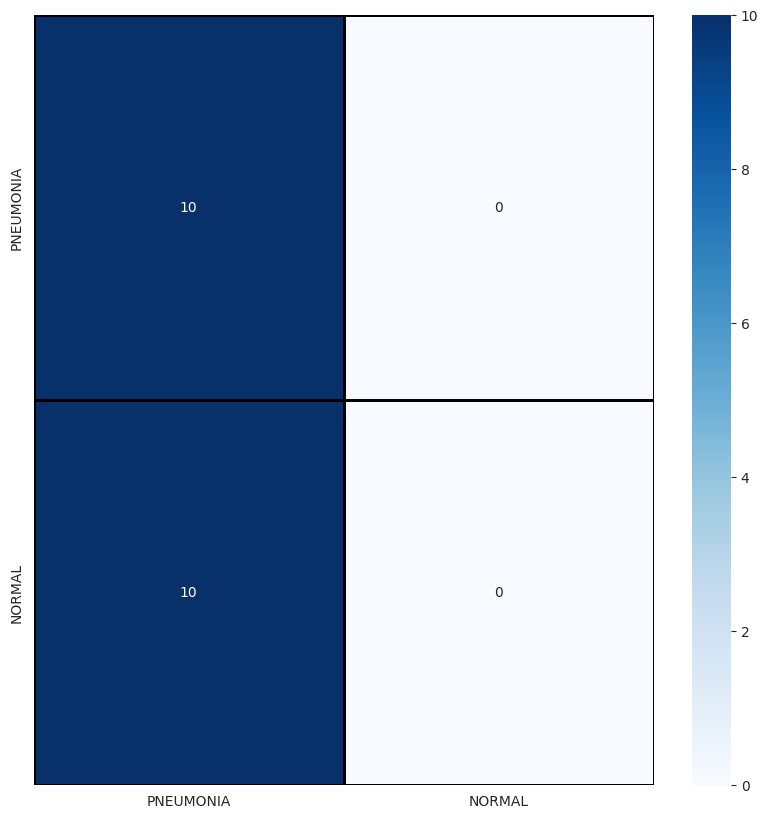

In [38]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [39]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [40]:
i = 0
for c in correct[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

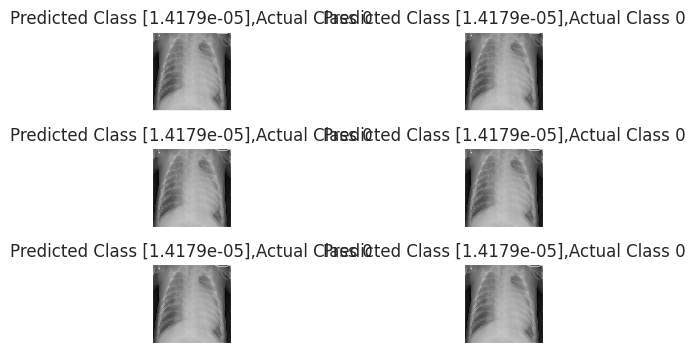

In [41]:
i = 0
for c in incorrect[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [44]:
model.save_weights('model_weights.h5')

In [45]:
pip install --upgrade fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
#importing libraries
from fastai import *
from fastai.vision.all import *
# from fastai.vision import ImageDataBunch
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np

In [47]:
x  = '/content/drive/MyDrive/Colab Notebooks/dataset/train'
condition = 'normal', 'pneunomonia'
path = Path(x)
path.ls()

(#3) [Path('/content/drive/MyDrive/Colab Notebooks/dataset/train/.DS_Store'),Path('/content/drive/MyDrive/Colab Notebooks/dataset/train/PNEUMONIA'),Path('/content/drive/MyDrive/Colab Notebooks/dataset/train/NORMAL')]

(1858, 2090)


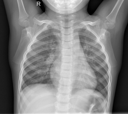

In [49]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/Colab Notebooks/dataset/train/NORMAL/IM-0115-0001.jpeg')
print(img.shape)
img.to_thumb(128,128)

In [50]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): 
        self.loaders = loaders
    def __getitem__(self, i): 
        return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [51]:
bears = DataBlock(
blocks=(ImageBlock, CategoryBlock),
get_items=get_image_files,
splitter=RandomSplitter(valid_pct=0.2, seed=42),
get_y=parent_label,
item_tfms=Resize(128))

In [52]:
dls = bears.dataloaders(path)

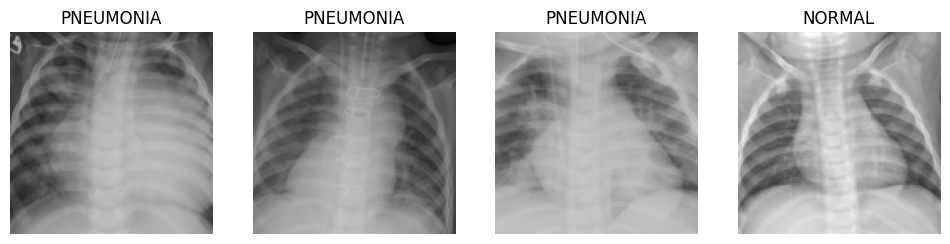

In [53]:
dls.valid.show_batch(max_n=4, nrows=1)

In [54]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pt

epoch,train_loss,valid_loss,error_rate,time
0,nan,3.051333,0.571429,00:04


/usr/local/lib/python3.9/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,error_rate,time
0,nan,3.051333,0.571429,00:04
1,nan,3.051333,0.571429,00:03
2,nan,3.051333,0.571429,00:03
3,nan,3.051333,0.571429,00:03


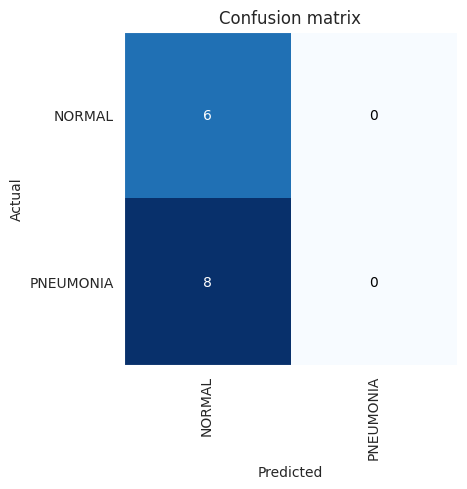

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

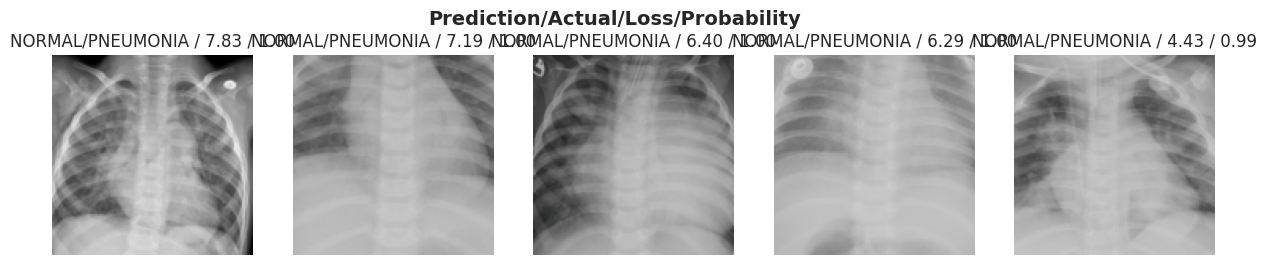

In [56]:
interp.plot_top_losses(5, nrows=1)

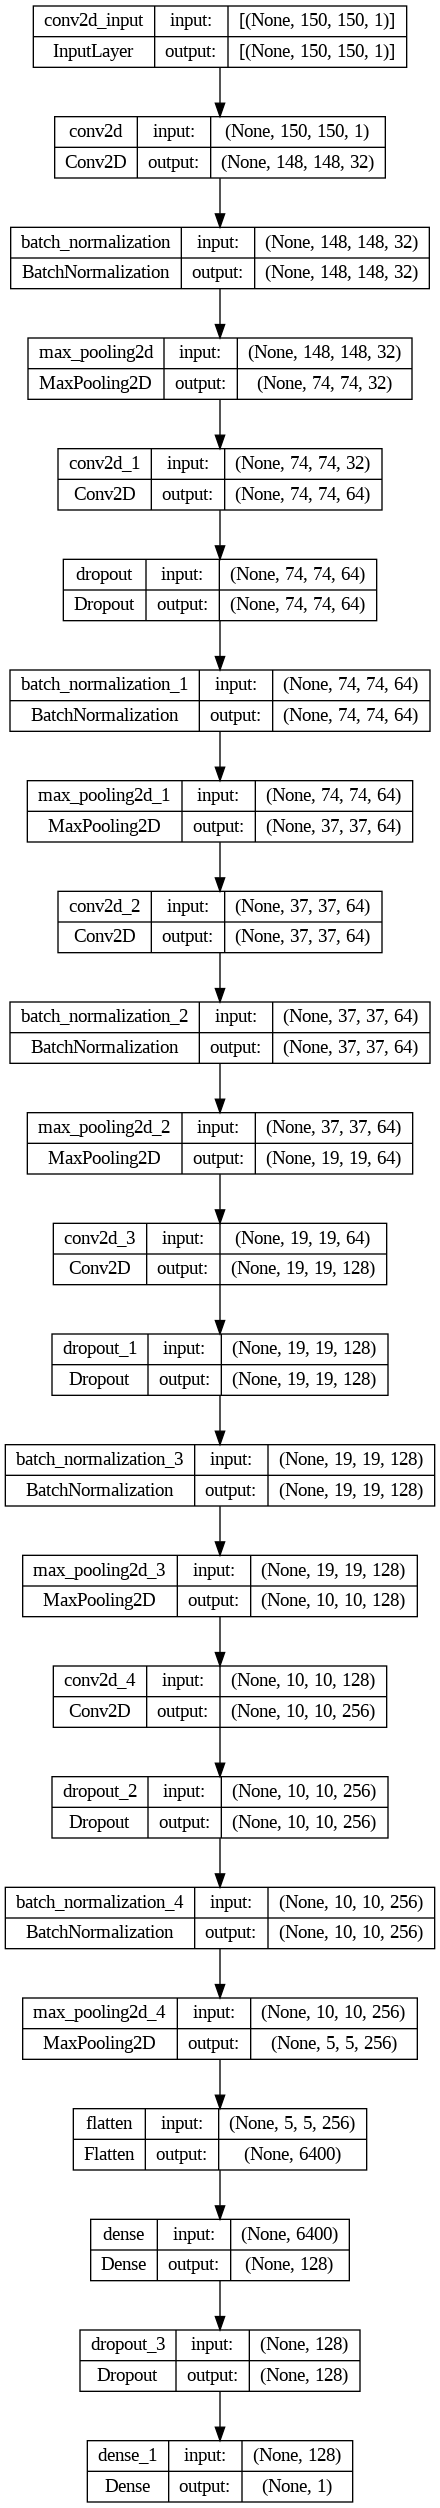

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

# Define the model architecture
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2, padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2, padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2, padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2, padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2, padding='same'),
    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid')
])

# Generate the workflow diagram and save it to a file
plot_model(model, to_file='model_workflow.png', show_shapes=True, show_layer_names=True)
